Channel is 51.2 for no time offset (4.5 ns)

In [58]:
import uncertainties.unumpy as unp
import uncertainties as u
from uncertainties.umath import log


from uncertainties import ufloat
import numpy as np
import pandas as pd
import scipy as sp
import kafe2
import matplotlib.pyplot as plt
import os
import glob
import struct
import sympy
from scipy.optimize import curve_fit
from scipy import special
from pathlib import Path



In [59]:
def gauss (x,A,sigma,µ):
    return A/np.sqrt(2*np.pi*sigma**2)*np.exp(-(x-µ)**2/(2*sigma**2))
directory =  Path().resolve()/Path("162")
directory_img =  Path().resolve()/Path("img")
if not os.path.exists(directory_img):
    os.makedirs(directory_img)


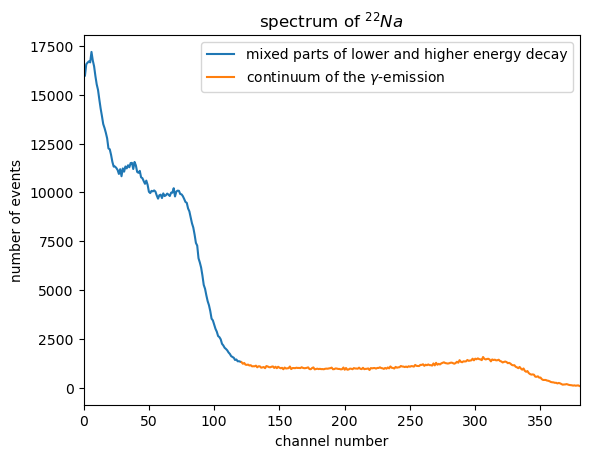

In [60]:
Na_22 = np.genfromtxt("./162/Na22_spectrum.txt")
cutoff=120
plt.title("spectrum of $^{22}Na$")
plt.ylabel("number of events")
plt.xlabel("channel number")
plt.plot(Na_22[:cutoff,0], Na_22[:cutoff,1], label="mixed parts of lower and higher energy decay")
plt.plot(Na_22[cutoff:,0], Na_22[cutoff:,1],label="continuum of the $\\gamma$-emission")
plt.legend()
plt.xlim(0,380)
plt.savefig(directory_img/Path("spectrum"))

plt.show()


3.46177345103938 51.64597905559373
3.781664977364748 102.24267333961834
3.665597766846442 152.05405224182542
4.181205420628854 202.38241330410548
3.59474740926155 253.57038385877425
3.899691802022015 303.71681651060345
3.5092904583649522 354.1309304871328
3.773057499773092 404.8734021490853
3.865861717275532 455.73431764473935


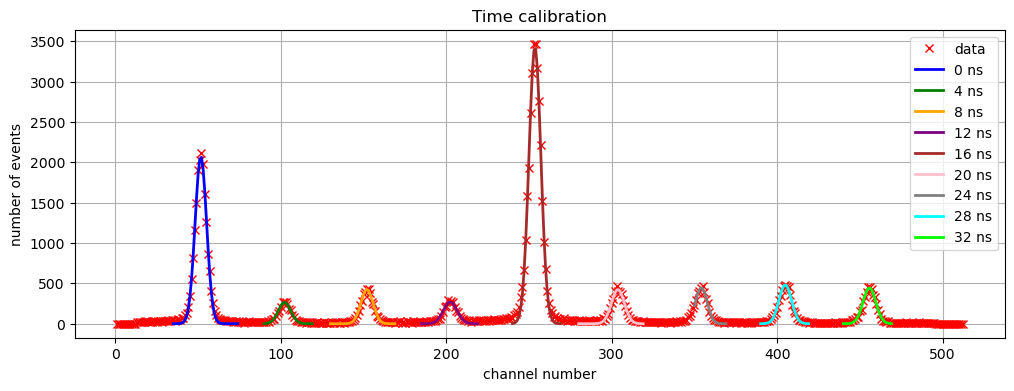

In [61]:
time_limit_list=[[35, 75], [90, 120], [130, 170], [185, 220], [240, 270], [280, 320], [350, 370], [390, 420], [440, 470]]
colors = ['blue','green','orange','purple', 'brown','pink', 'gray', 'cyan', 'lime']
t_mu_list=[]
t_error_list=[]
arr = np.genfromtxt(directory/"Zeitaulsg.txt").T
# plt.plot(arr[0],arr[1])
# plt.grid(1)
# plt.show()


x = np.linspace(0,500,501)
plt.figure(figsize=(12, 4))
plt.plot(arr[0],arr[1], "rx", label="data")

for i,limit in enumerate(time_limit_list):

    p_0 = [2000, 10, (limit[0]+limit[1])/2]

    par, cov= curve_fit(gauss, arr[0][limit[0]:limit[1]], arr[1][limit[0]:limit[1]], p0= p_0)
    sigma, mu = np.abs(par[1]), par[2]
    print(sigma, mu)

    n_events = np.sum(arr[1][round(mu-sigma)-1:round(mu+sigma)-1]) ## sum of events in one sigma interval
    t_error_list.append(sigma/np.sqrt(n_events))
    t_mu_list.append(mu)
    plt.plot(x[limit[0]:limit[1]], gauss(x, par[0],par[1],par[2])[limit[0]:limit[1]],label = str(i*4)+" ns",linewidth = 2,color=colors[i])

plt.title("Time calibration")
plt.grid(1)
plt.legend()
# plt.xlim(limit[0], limit[1])
plt.xlabel("channel number")
plt.ylabel("number of events")
plt.savefig(directory_img/Path("time calibration"))

plt.show()

times_cal_arr = unp.uarray(t_mu_list,t_error_list)

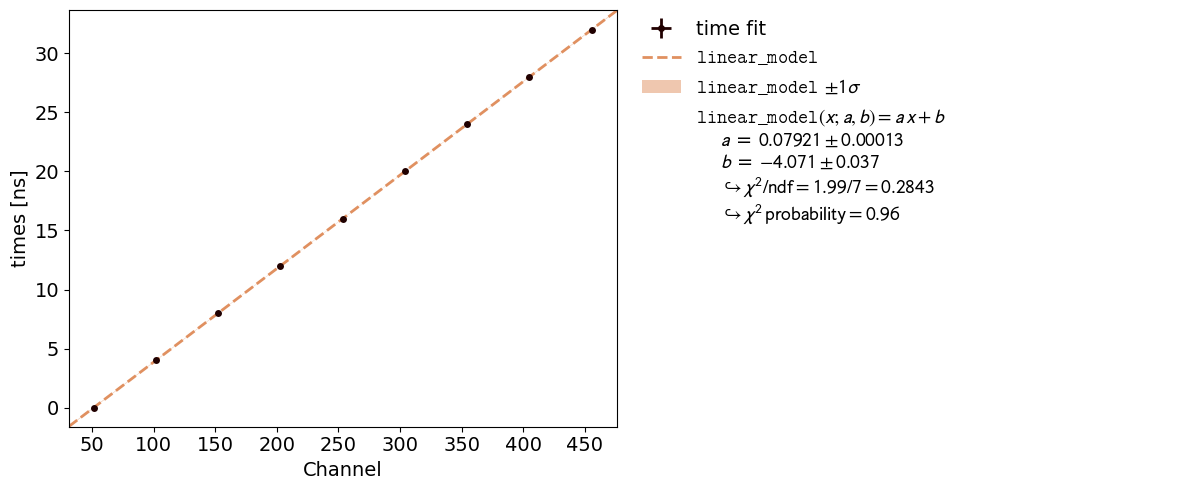

-0.807989019651334+/-0.07588602896705467

In [62]:

data = kafe2.XYContainer(unp.nominal_values(times_cal_arr), range(0,33,4))
data.label = 'time fit'
#print(times_cal_arr)
data.add_error('x', unp.std_devs(times_cal_arr))
data.add_error('y', 0.05)


fit_time = kafe2.Fit(data)
fit_time.do_fit()
p = kafe2.Plot(fit_time)
p.y_label = 'times [ns]'
p.x_label = 'Channel' 
p.plot()
plt.savefig(directory_img/Path("time fit"))

plt.show()

def timeConversion(channel,error=False):
    """
    returns the corresponding time

    Args:
        float/ufloat: time
        error: return ufloat

    Returns:
        float: time [ns]
        ufloat: time [ns]
    """
    global fit_time
    
    if error:
        return (u.ufloat(fit_time.parameter_values[0], fit_time.parameter_errors[0])*channel+u.ufloat(fit_time.parameter_values[1], fit_time.parameter_errors[1]))
    return (fit_time.parameter_values[0]*channel+fit_time.parameter_values[1])

timeConversion(300,True)-timeConversion(310.2,True)

$N(t)=A\cdot e^{-\frac{t}{\tau_1}}+B\cdot e^{-\frac{t}{\tau_2}}+C$

<>:7: SyntaxWarning: invalid escape sequence '\D'
<>:7: SyntaxWarning: invalid escape sequence '\D'
C:\Users\jonah\AppData\Local\Temp\ipykernel_19552\776786775.py:7: SyntaxWarning: invalid escape sequence '\D'
  plt.xlabel("$\Delta t$ [ns]")


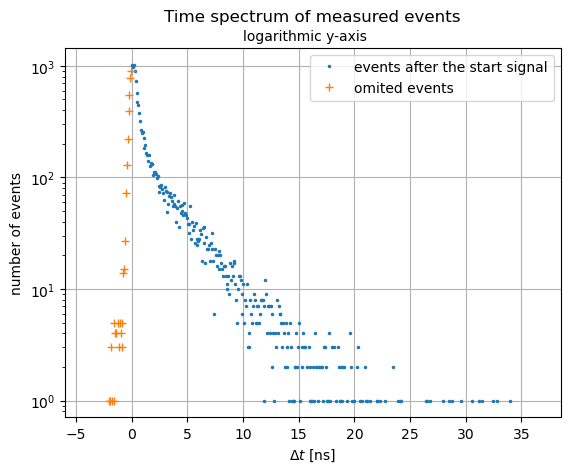

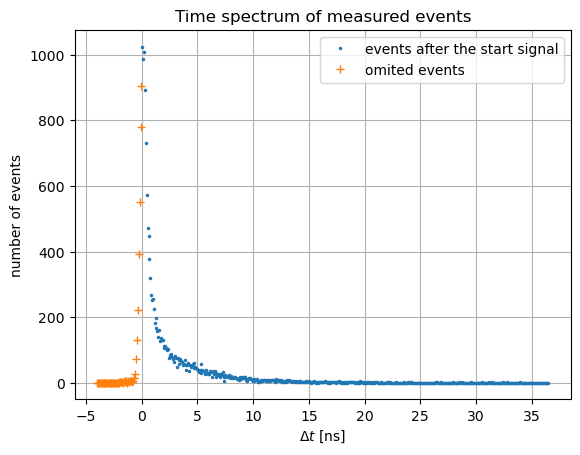

In [63]:
dif_time = np.genfromtxt("./162/Zeitmessung.txt").T
cutoff=51
plt.plot(timeConversion(dif_time[0][cutoff:]), dif_time[1][cutoff:],".",markersize=3, label="events after the start signal")

plt.plot(timeConversion(dif_time[0][0:cutoff]), dif_time[1][0:cutoff],"+",label="omited events")
plt.grid(1)
plt.xlabel("$\Delta t$ [ns]")
plt.ylabel("number of events")
plt.legend()
plt.title("Time spectrum of measured events",y= 1.05)
plt.suptitle("logarithmic y-axis",fontsize=10, y=0.92)
plt.yscale("log")

plt.savefig(directory_img/Path("decay log"))
plt.show()


plt.plot(timeConversion(dif_time[0][cutoff:]), dif_time[1][cutoff:],".",markersize=3, label="events after the start signal")

plt.plot(timeConversion(dif_time[0][0:cutoff]), dif_time[1][0:cutoff],"+",label="omited events")
plt.grid(1)
plt.xlabel("$\\Delta t$ [ns]")
plt.ylabel("number of events")
plt.legend()
plt.title("Time spectrum of measured events")
plt.savefig(directory_img/Path("decay"))
# plt.yscale("log")
plt.show()



In [196]:
cutoff=0
def decay(t,tau_1=0.442 , tau_2=3.731 , A=879, B=171, C=-0.042, sigma=-0.4822):    
    result = np.zeros_like(t)
    mask_positive = t >= 0
    result[mask_positive] = (A * np.exp(-t[mask_positive] / tau_1) + B * np.exp(-t[mask_positive] / tau_2) +C)
    
    mask_negative = t < 0
    result[mask_negative] = (gauss(t[mask_negative],A+B,sigma,0))
    
    return result

def modified_gauss(t, A, lamb,sigma, mu ):
	
    return A*np.exp( (lamb/(2)) * ( 2*mu + sigma**2*lamb - 2*t ) ) * (1 - special.erf(mu + sigma**2*lamb - t) / (np.sqrt(2)*sigma) )


def decay_modified(t,  B=3.3, A=1.3, C=0, sigma=0.1, mu = -0.7, lambda_1 = 3.7 , lambda_2 = 0.52 ):    
    return modified_gauss(t, A , lambda_1 , sigma , mu ) + modified_gauss(t, B , lambda_2 ,sigma , mu ) + C

data = kafe2.XYContainer(timeConversion(dif_time[0][cutoff:]), dif_time[1][cutoff:])
data.label = 'decay fit'
data.add_error('x', timeConversion(53.5)-timeConversion(50))
data.add_error('x', unp.std_devs(timeConversion(dif_time[0][cutoff:],True) ) )
data.add_error('y', 0.1)
fit_decay = kafe2.Fit(data,decay)
fit_decay.do_fit()

data.label = 'modified decay fit'

data.add_error('x', unp.std_devs(timeConversion(dif_time[0][cutoff:],True) ) )
data.add_error('y', 0.1)
modified_fit_decay = kafe2.Fit(data,decay_modified)
modified_fit_decay.do_fit();




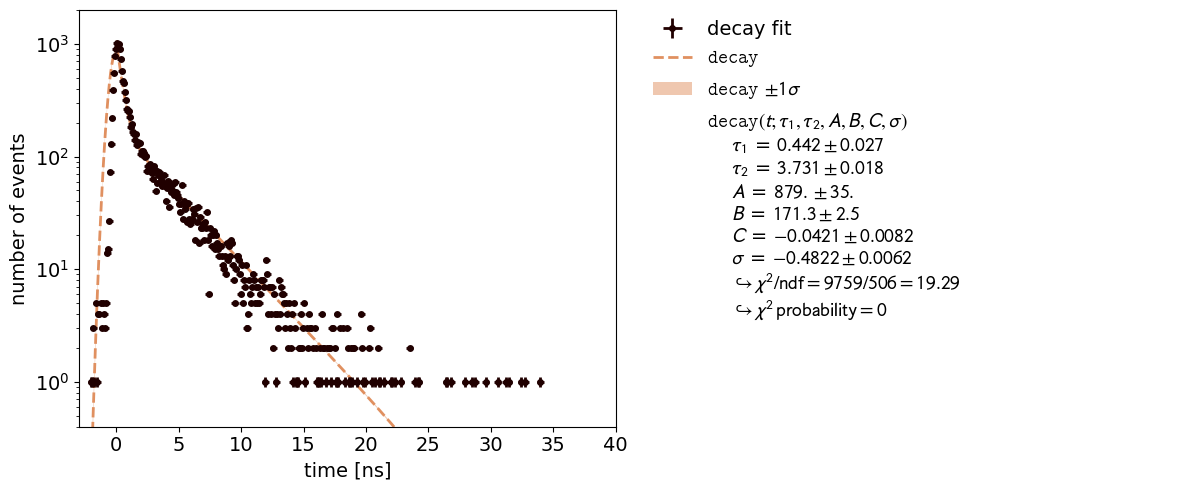

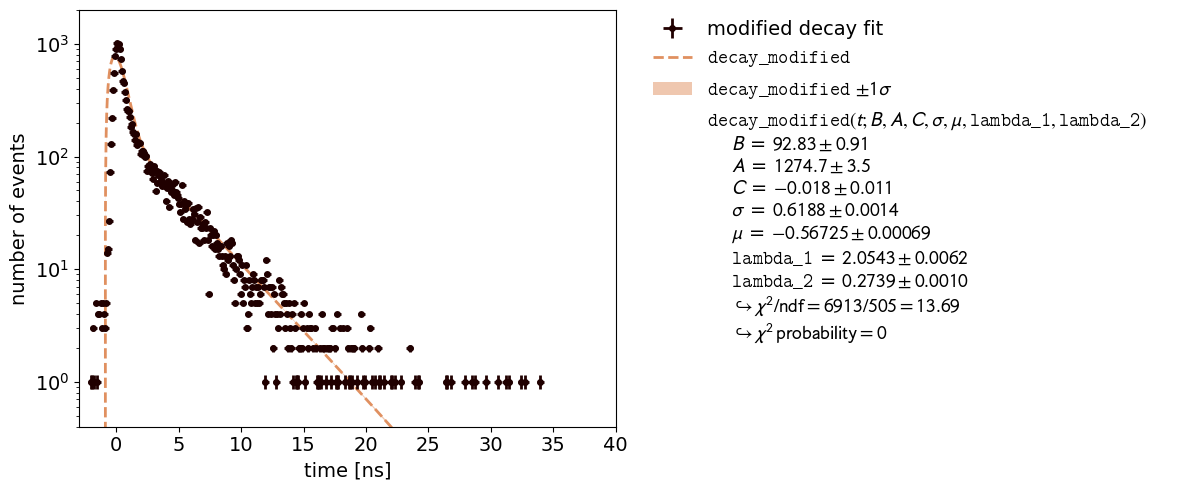

0.27725113419408487
A 388+/-28 0.442+/-0.027 B 639+/-10 3.731+/-0.018
A 620.5+/-2.5 0.4868+/-0.0015 B 339+/-4 3.652+/-0.014
Verhältniss 0.61+/-0.05 1.65+/-0.12
Alternativ 1.831+/-0.021
0.4868+/-0.0015 3.652+/-0.014


(None, None, None, None, None)

In [205]:

p = kafe2.Plot(fit_decay)
p.x_label = 'time [ns]'
p.y_label = 'number of events' 
p.x_range = (-3, 40)
p.y_scale ="log"
p.y_range = (0.4, 2000)

p.plot()
plt.savefig(directory_img/Path("decay fit log"))

plt.show()


p = kafe2.Plot(modified_fit_decay)
p.x_label = 'time [ns]'
p.y_label = 'number of events' 
p.x_range = (-3, 40)
p.y_scale ="log"
p.y_range = (0.4, 2000)

p.plot()
plt.savefig(directory_img/Path("decay fit"))
plt.show()

tau_1_modified =  1/u.ufloat(modified_fit_decay.parameter_values[5], modified_fit_decay.parameter_errors[5])
tau_2_modified =  1/u.ufloat(modified_fit_decay.parameter_values[6], modified_fit_decay.parameter_errors[6])


tau_1 =  u.ufloat(fit_decay.parameter_values[0], fit_decay.parameter_errors[0])
tau_2 =  u.ufloat(fit_decay.parameter_values[1], fit_decay.parameter_errors[1])

A =  u.ufloat(fit_decay.parameter_values[2], fit_decay.parameter_errors[2])*tau_1
B =  u.ufloat(fit_decay.parameter_values[3], fit_decay.parameter_errors[3])*tau_2

A1 =  u.ufloat(modified_fit_decay.parameter_values[1], modified_fit_decay.parameter_errors[1])*tau_1_modified
B1 =  u.ufloat(modified_fit_decay.parameter_values[0], modified_fit_decay.parameter_errors[0])*tau_2_modified

print(timeConversion(53.5)-timeConversion(50))
print("A",A,tau_1,"B",B,tau_2),print("A",A1, tau_1_modified,"B",B1,tau_2_modified), print("Verhältniss",A/B, B/A), print("Alternativ",A1/B1),print(tau_1_modified, tau_2_modified )

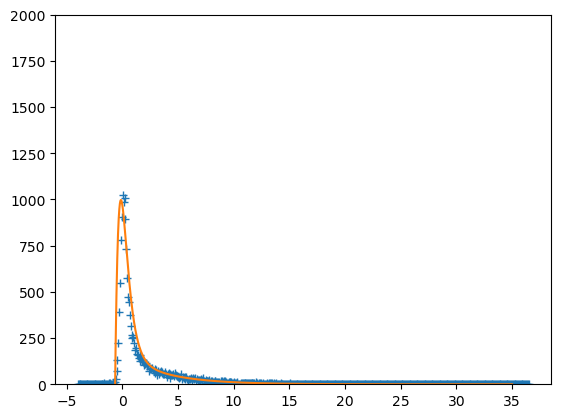

In [146]:
x = np.linspace(-2,35, 10000)
plt.plot(timeConversion(dif_time[0][cutoff:]), dif_time[1][cutoff:], "+")
plt.plot(x,decay(x, A=0.406023, B=1.3629, C=0, sigma=0.0002009, mu = -0.64, tau_1 = 3.75 , tau_2 = 0.581 ))

plt.ylim(0, 2000)
# plt.yscale("log")
plt.show()

<>:24: SyntaxWarning: invalid escape sequence '\s'
<>:24: SyntaxWarning: invalid escape sequence '\s'
C:\Users\jonah\AppData\Local\Temp\ipykernel_19552\1883680190.py:24: SyntaxWarning: invalid escape sequence '\s'
  plt.bar(timeConversion(arr[0][round(mu - sigma) - 1:round(mu + sigma) - 1]), arr[1][round(mu - sigma) - 1:round(mu + sigma) - 1], 0.05, color = "blue", alpha = 0.3, label= "events in 1$\sigma$")


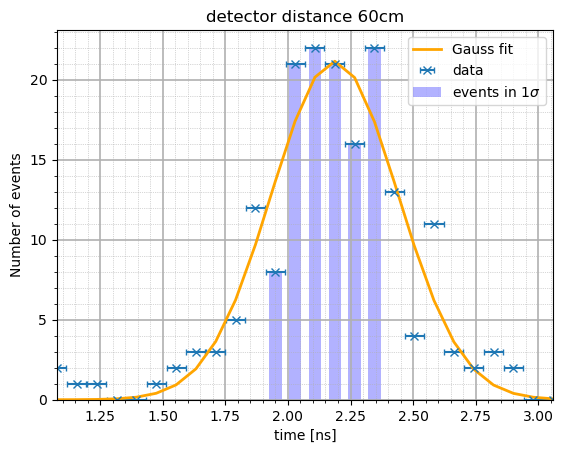

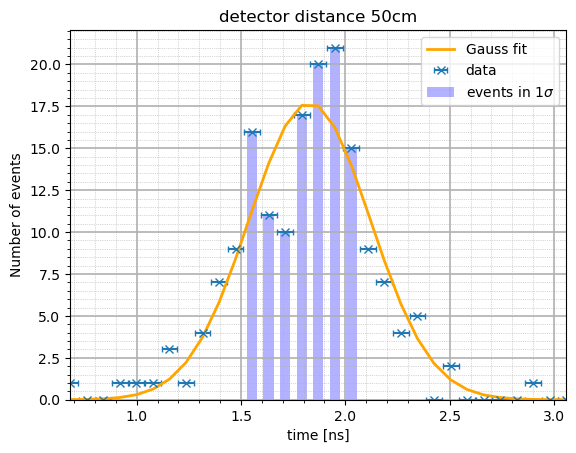

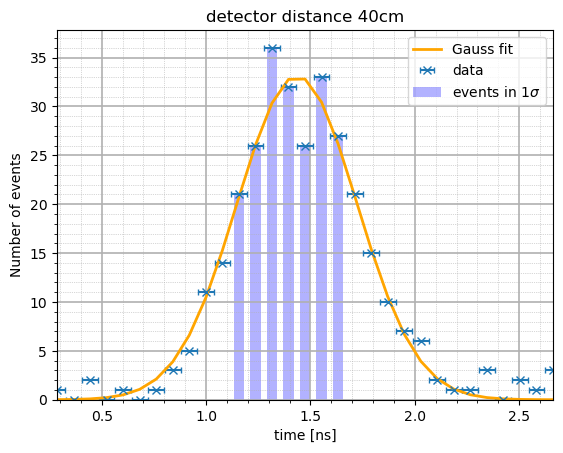

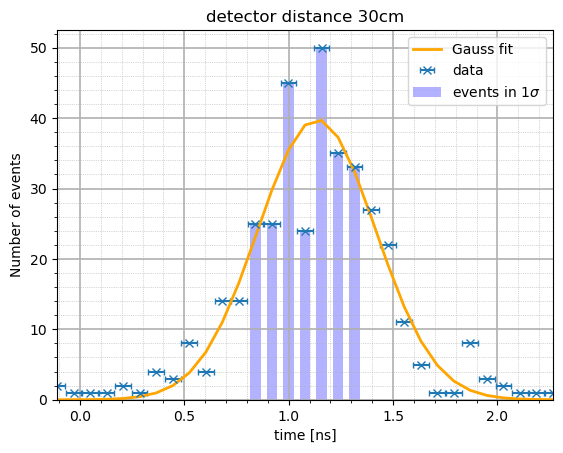

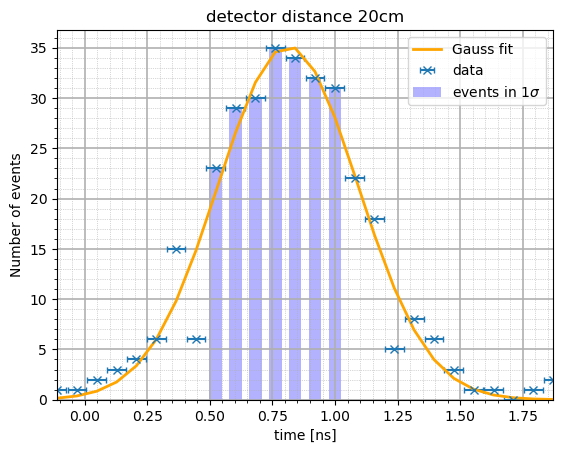

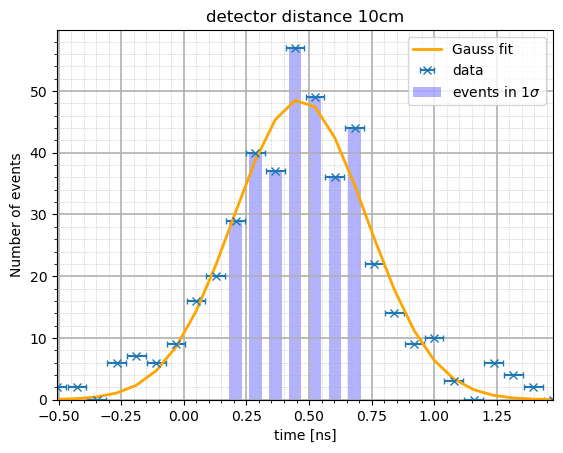

In [207]:
c_file_list = [[x, x.split(".")[-2].split("\\")[-1]] for x in sorted(glob.glob(os.path.join(directory, '*.txt')), key=os.path.getmtime, reverse=True) if ("cm" in x)]
limit_list=[[65,90],[60,90],[55,85],[50,80],[50,75],[45,70]]

c_mu_list=[]
c_error_list=[]


x = np.linspace(0, 100, 101)

for i, file in enumerate(c_file_list):
    arr = np.genfromtxt(file[0]).T
    plt.errorbar(timeConversion(arr[0]), arr[1], xerr=unp.std_devs(timeConversion(arr[0],True)) ,label="data",fmt="x",capsize=2)
    beg_ch = 30
    end_ch = 80
    p_0 = [20, 10, (end_ch + beg_ch) / 2]

    par, cov = curve_fit(gauss, arr[0], arr[1], p0=p_0)
    sigma, mu = np.abs(par[1]), par[2]
    n_events = np.sum(arr[1][round(mu - sigma) - 1:round(mu + sigma) - 1])  # sum of events in one sigma interval
    c_error_list.append(sigma / np.sqrt(n_events))
    c_mu_list.append(mu)
    plt.plot(timeConversion(x), gauss(x, par[0], par[1], par[2]), "orange", label="Gauss fit", linewidth=2)

    plt.bar(timeConversion(arr[0][round(mu - sigma) - 1:round(mu + sigma) - 1]), arr[1][round(mu - sigma) - 1:round(mu + sigma) - 1], 0.05, color = "blue", alpha = 0.3, label= "events in 1$\sigma$")

    plt.ylabel("Number of events")
    plt.xlabel("time [ns]")
    plt.title("detector distance " + str(file[1]))
    plt.minorticks_on()  # Turn on minor ticks
    plt.grid(visible=True, which='both', linestyle='-', linewidth=1.2, alpha=1)  # Major and minor grids
    plt.grid(visible=True, which='minor', linestyle=':', linewidth=0.5, alpha=1) 
    
    plt.legend()
    plt.xlim(timeConversion(limit_list[i][0]), timeConversion(limit_list[i][1]))
    plt.savefig(directory_img/Path("detector distance " + str(file[1])))
    plt.show()

c_times = timeConversion(unp.uarray(c_mu_list, c_error_list), True) * 1e-9



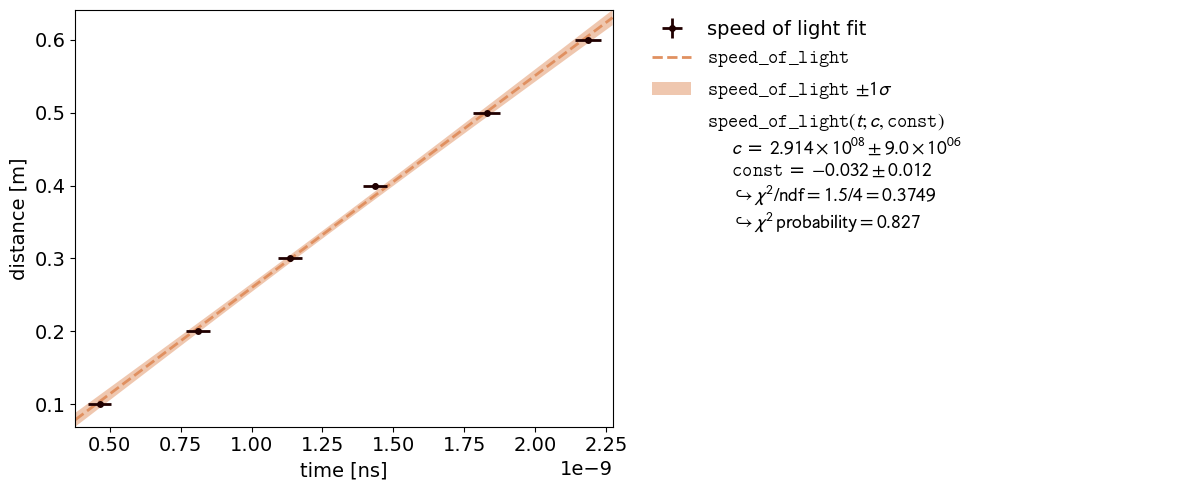

In [66]:
def speed_of_light(t,c,const):
    return c*t+const
data = kafe2.XYContainer(unp.nominal_values(c_times),[0.6, 0.5, 0.4, 0.3, 0.2, 0.1])
data.label = 'speed of light fit' 
data.add_error('x', unp.std_devs(c_times))
data.add_error('y', 0.003)
fit_c = kafe2.Fit(data,speed_of_light)
fit_c.do_fit()
p = kafe2.Plot(fit_c)
p.x_label = 'time [ns]'
p.y_label = 'distance [m]' 
p.plot()
plt.savefig(directory_img/Path("speed of light fit"))

plt.show()